---
---
## Perkenalan

Nama        : I Made Dhanan Pradipta <br> 
Batch       : 10

Objective   :   
1.    Objectif yang ingin didapat dalam pembuatan model regresi ini adalah, bagaimana caranya menentukan konsumsi bensin/gas pada kendaraan roda empat, dengan spesifikasi dari kendaraan tersebut <br>
2.    Tujuan yang kedua adalah untuk mebandingkan empat buat metode regresi yang mana lebih cocok dalam memprediksi bahan bakar mobil <br>
3.    Membuat sistem pipeline pada model, yang dapat diexport nantinya untuk bisa dideployment kedalam web/api

Dataset     : Diambil dari web https://archive.ics.uci.edu/ml/datasets/Auto+MPG oleh Ross Quinan (1993)

---
---
## Import Library

In [39]:
#pandas for dataframe proces
#matplotlib and seaborn for viz
#sklearn for model processing

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


---
---
## Data Loading

In [40]:
#open using pandas
#'?' value convert to Nan

df = pd.read_csv('auto-mpg.csv', na_values='?')

In [41]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


In [43]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


---
---
## Exploratory Data Analysis (EDA)

1.  Variable Analysis
2.  Univariate Analysis
3.  Bivariate Analysis
4.  Multivariate Analysis

### 1.  Variable Analysis

In [44]:
cars_df = df.copy()

Target regresi adalah _mpg_ yaitu miles per galon, dimana memiliki arti seberapa jauh jarak tempuh suatu perjalanan menggunakan mobil dalam sekali pengisian 1 galon bahan bakar,<br>
karena miles dan galon merupakan satuan yang biasa digunakan di US dan untuk memudahkan dalam pendefinisian, maka diubah _mpg_ menjadi _km/l_ yaitu kilometer per 1 liter, dengan formula <br>


$1 mpg  = 0.425144  km/L $

In [45]:
cars_df['km/l'] = cars_df['mpg'] * 0.425144
cars_df.drop('mpg', axis=1, inplace=True)

salah satu feature yaitu _horsepower_ diganti typenya menjadi numeric yang sebelumnya object

In [46]:
cars_df['horsepower'] = pd.to_numeric(df['horsepower'])

feature lainya yang dimodifikasi adalah _car name_, dimana dari column tersebut dibuat column baru yaitu _brand_

In [47]:
brand_label = []
for name in cars_df['car name']:
    brand_label.append(name.split()[0])

cars_df['brand'] = brand_label

In [48]:
misspelled = {'chevroelt': 'chevrolet',
               'chevy': 'chevrolet',
               'vokswagen': 'volkswagen',
               'vw': 'volkswagen',
               'hi': 'harvester',
               'maxda': 'mazda',
               'toyouta': 'toyota',
               'mercedes-benz': 'mercedes'}

for brand in cars_df['brand']:
    for key, value in misspelled.items():
        if brand == key:
            cars_df['brand'] = cars_df['brand'].replace(brand, value)

In [49]:
cars_df

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,km/l,brand
0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,7.652592,chevrolet
1,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,6.377160,buick
2,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,7.652592,plymouth
3,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,6.802304,amc
4,8,302.0,140.0,3449,10.5,70,1,ford torino,7.227448,ford
...,...,...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790,15.6,82,1,ford mustang gl,11.478888,ford
394,4,97.0,52.0,2130,24.6,82,2,vw pickup,18.706336,volkswagen
395,4,135.0,84.0,2295,11.6,82,1,dodge rampage,13.604608,dodge
396,4,120.0,79.0,2625,18.6,82,1,ford ranger,11.904032,ford


### 2.  Univariate Analysis

In [50]:
num_columns = cars_df.select_dtypes(['int64', 'float64']).columns
cat_columns = cars_df.select_dtypes(['object', 'bool']).columns

print("numerical columns : ", num_columns)
print()
print("categorical columns : ", cat_columns)

numerical columns :  Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin', 'km/l'],
      dtype='object')

categorical columns :  Index(['car name', 'brand'], dtype='object')


Analisis column disini diambil satu contoh yaitu _brand_

In [51]:
g_brand = cars_df.groupby('brand').size().reset_index(name="counts")

fig = px.pie(g_brand, values='counts', names='brand', title='Brand Total')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.update_layout(
    autosize=False,
    width=500,
    height=500,)
fig.show()

Kesimpulanya, _brand_ terbanyak pada dataset yaitu __ford__ dengan 12.8% dari keseluruhan dataset

### 3.  Bivariate Analysis

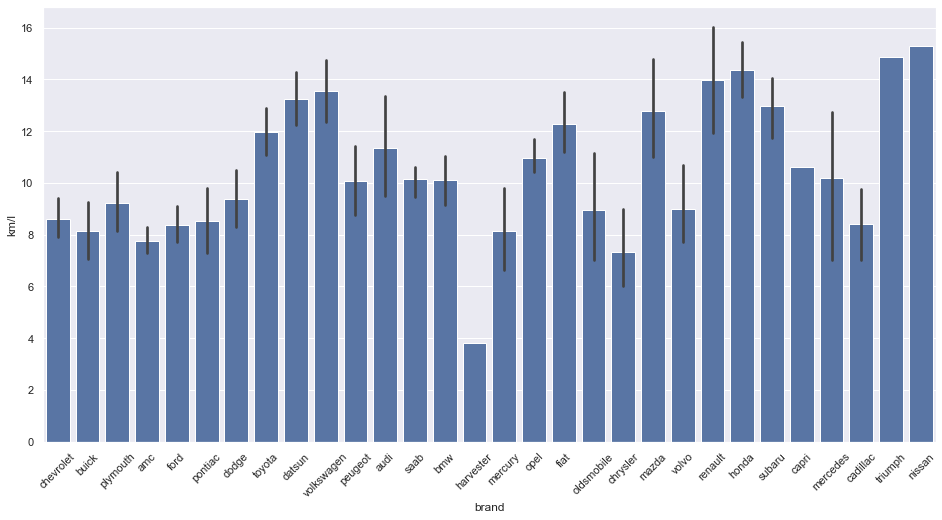

In [52]:
plt.figure(figsize=(16,8))
sns.barplot(x="brand", y="km/l", data=cars_df,
            color="b")
plt.xticks(rotation=45)
plt.show()

Jika dilihat dari seberapa boros atau iritnya suatu merk mobil, disimpulkan bahwa __nissan__ menjadi mobil yang paling irit bahan bakar

In [53]:
power_car = cars_df.groupby('car name').agg('horsepower').mean().sort_values(ascending=False).reset_index().head(5)
weight_car = cars_df.groupby('car name').agg('weight').mean().sort_values(ascending=False).reset_index().head(5)

<AxesSubplot:xlabel='weight', ylabel='car name'>

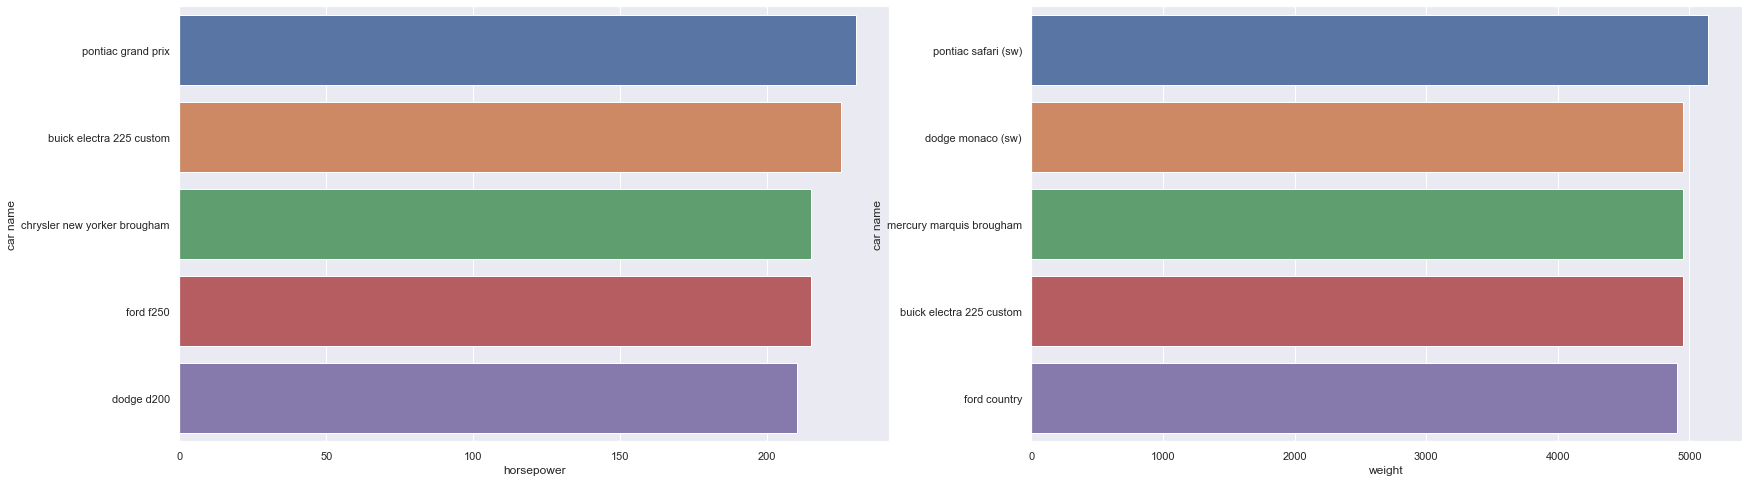

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(28, 8))
sns.barplot(x='horsepower', y='car name', data=power_car, ax=axs[0])
sns.barplot(x='weight', y='car name', data=weight_car, ax=axs[1])

Untuk _horsepower_ dan _weight_ mobil, didapat bahwa urutan pertama yang memiliki kekuatan paling tinggi yaitu __pontiac grand prix__, sedangkan untuk berat yaitu __pontiac safari__

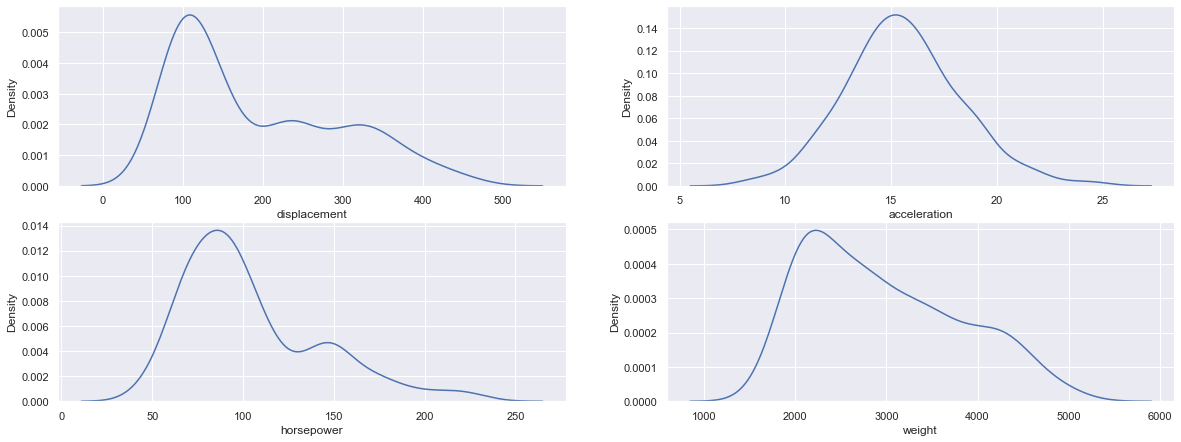

In [55]:
num = ['displacement', 'acceleration', 'horsepower', 'weight']

plt.figure(figsize=(20,35))
for i, j in enumerate(cars_df[num]):
    ax = plt.subplot(9, 2, i+1)
    sns.kdeplot(cars_df[j], ax=ax)
    plt.xlabel(j)

distribusi dari column, terlihat dataset cukup bagus karena distribusi tidak terlalu skew dan cenderung mengarah ke normal 

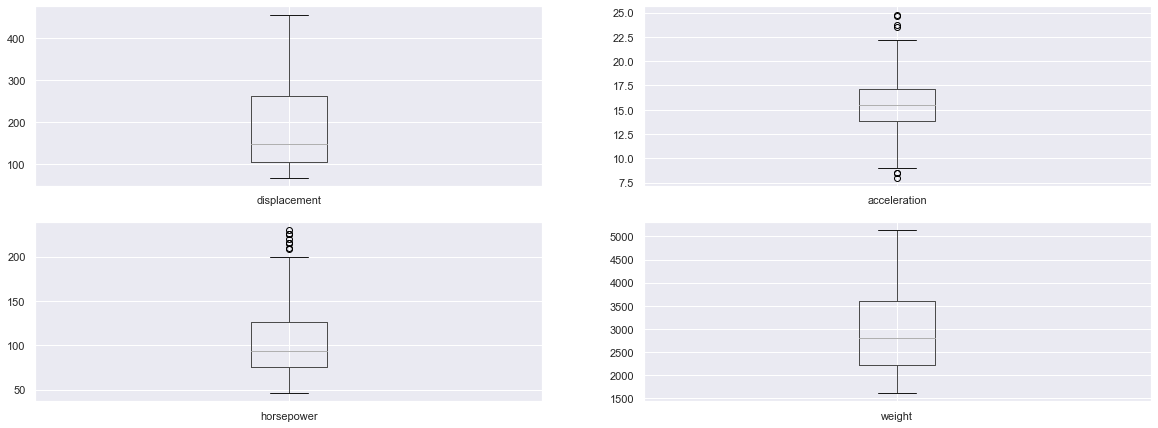

In [56]:
plt.figure(figsize=(20,35))
for i, j in enumerate(cars_df[num]):
    ax = plt.subplot(9, 2, i+1)
    cars_df.boxplot(column=j)

dari sisi outlier, terdapat outlier pada column _horsepower_ dan juga _acceleration_

### 4.  Multivariate Analysis

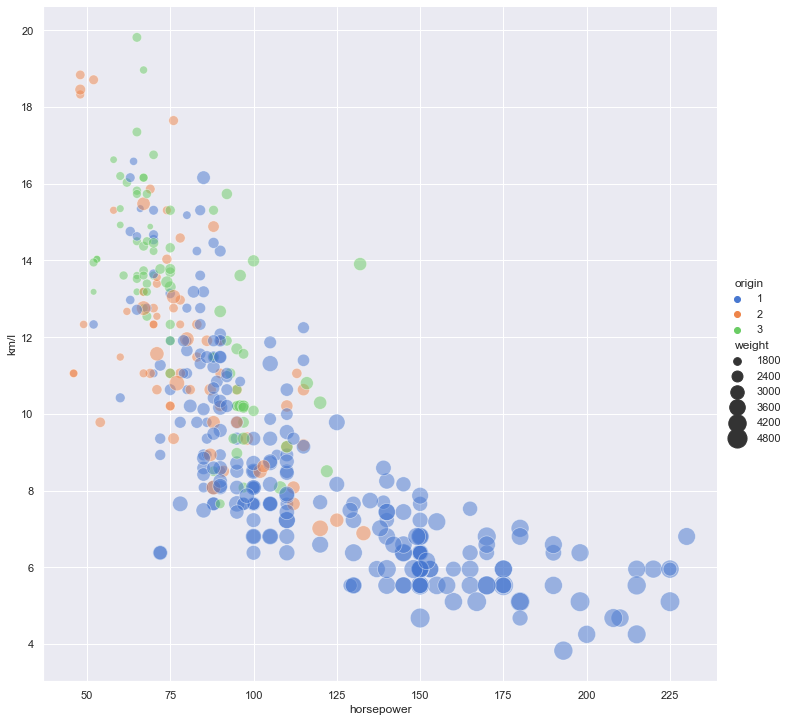

In [57]:
sns.relplot(x="horsepower", y="km/l", hue="origin", size="weight",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=10, data=cars_df)

grafik di atas menjelaskan sifat column horsepower berbanding lurus dengan weigh, yang rata-rata semkain tinggi hp, semakin berat pula weightnya, namun untuk konsumsi bahan bakar tidak terlalu boros, dan kebanyakan dari origin 2 atau 3 yang lebih boros

<AxesSubplot:>

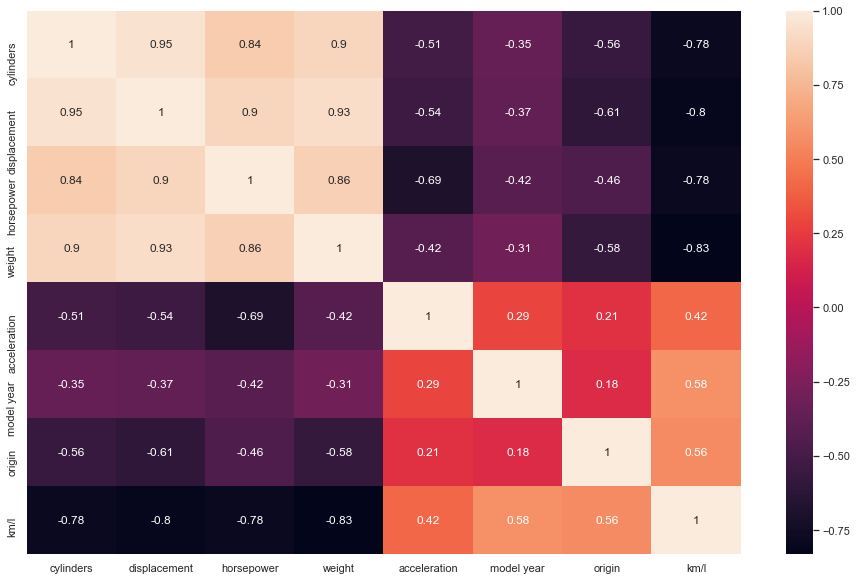

In [58]:
plt.figure(figsize=(16,10))
sns.heatmap(cars_df.corr(),annot=True)

Berdasarkan tabel korelasi di atas, dapat disimpulkan bahwa terdapat korelasi yang cukup tinggi antara feature dengan target

---
---
## Preprocessing

1.  Train test split
2.  Handling Missing Value
3.  handling Outlier
4.  Scaling Numerical Data
5.  Encode Categorical Data

### 1.  Train Test Split Data  

In [59]:
cars_df.drop('car name', axis=1, inplace=True)

In [60]:
X = cars_df.drop(['km/l'], axis=1)
y = cars_df['km/l']

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("Input Training:",X_train.shape)
print("Input Test:",X_test.shape)
print("Output Training:",y_train.shape)
print("Output Test:",y_test.shape)

Input Training: (318, 8)
Input Test: (80, 8)
Output Training: (318,)
Output Test: (80,)


In [62]:
num_col = X.select_dtypes(['int64', 'float64']).columns
cat_col = X.select_dtypes(['object', 'bool']).columns

### 2.  Handling Missing Value 

In [63]:
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(X_train[num_col])
X_train[num_col] = imputer.transform(X_train[num_col])
X_test[num_col] = imputer.transform(X_test[num_col])

<ipython-input-63-c7edfa60f0e1>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\danan\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-c7edfa60f0e1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

### 3.  Anomaly Detection

In [64]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train[num_col])

mask = yhat != -1
X_train, y_train = X_train.iloc[mask, :], y_train[mask]

print(X_train.shape, y_train.shape)

(286, 8) (286,)


### 4.  Scaling and Encoding Using ColumnTransformer  

In [65]:
data_pipeline = ColumnTransformer([
    ('pipe_num', StandardScaler(), num_col),
    ('pipe_cat', OneHotEncoder(), cat_col)
])

In [66]:
def pipeline_model(model):
    final_pipeline = Pipeline([
        ('prep', data_pipeline),
        ('model', model)
    ])
    return final_pipeline

---
---
## Model Definition

In [67]:
lr = pipeline_model(LinearRegression())

knn = pipeline_model(KNeighborsRegressor())

rd = pipeline_model(Ridge())

xgb = pipeline_model(XGBRegressor())

---
---
## Model Training

In [68]:
lr.fit(X_train, y_train)

knn.fit(X_train, y_train)

rd.fit(X_train, y_train)

xgb.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('pipe_num', StandardScaler(),
                                                  Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin'],
      dtype='object')),
                                                 ('pipe_cat', OneHotEncoder(),
                                                  Index(['brand'], dtype='object'))])),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                            

In [69]:
cat_enc_name = data_pipeline.named_transformers_['pipe_cat'].get_feature_names(cat_col)
columns = np.append(cat_enc_name, num_col)

In [70]:
columns

array(['brand_amc', 'brand_audi', 'brand_bmw', 'brand_buick',
       'brand_cadillac', 'brand_capri', 'brand_chevrolet',
       'brand_chrysler', 'brand_datsun', 'brand_dodge', 'brand_fiat',
       'brand_ford', 'brand_honda', 'brand_mazda', 'brand_mercedes',
       'brand_mercury', 'brand_nissan', 'brand_oldsmobile', 'brand_opel',
       'brand_peugeot', 'brand_plymouth', 'brand_pontiac',
       'brand_renault', 'brand_saab', 'brand_subaru', 'brand_toyota',
       'brand_triumph', 'brand_volkswagen', 'brand_volvo', 'cylinders',
       'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin'], dtype=object)

In [71]:
print("--- Training-Set ---")
display(X_train)
print("--- After Transform ---")
display(pd.DataFrame((data_pipeline.transform(X_train)).toarray(), columns=columns))

# Inspect test data before and after
print("--- Test data ---")
display(X_test)
print("--- After Transform ---")
display(pd.DataFrame((data_pipeline.transform(X_test)).toarray(), columns=columns))

--- Training-Set ---


,cylinders,displacement,horsepower,weight,acceleration,model year,origin,brand
303,4.0,85.0,65.0,2020.0,19.2,79.0,3.0,datsun
347,4.0,85.0,65.0,1975.0,19.4,81.0,3.0,datsun
149,4.0,120.0,97.0,2489.0,15.0,74.0,3.0,honda
100,6.0,250.0,88.0,3021.0,16.5,73.0,1.0,ford
175,4.0,90.0,70.0,1937.0,14.0,75.0,2.0,volkswagen
...,...,...,...,...,...,...,...,...
369,4.0,112.0,88.0,2395.0,18.0,82.0,1.0,chevrolet
320,4.0,119.0,92.0,2434.0,15.0,80.0,3.0,datsun
15,6.0,198.0,95.0,2833.0,15.5,70.0,1.0,plymouth
125,6.0,198.0,95.0,3102.0,16.5,74.0,1.0,plymouth


--- After Transform ---


,brand_amc,brand_audi,brand_bmw,brand_buick,brand_cadillac,brand_capri,brand_chevrolet,brand_chrysler,brand_datsun,brand_dodge,...,brand_triumph,brand_volkswagen,brand_volvo,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,-0.828143,-1.074722,-1.095818,-1.141900,1.479603,0.780139,1.865580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.828143,-1.074722,-1.095818,-1.196713,1.560771,1.335855,1.865580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.828143,-0.719374,-0.139316,-0.570618,-0.224913,-0.609150,1.865580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.371092,0.600487,-0.408332,0.077404,0.383843,-0.887008,-0.675162,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.828143,-1.023958,-0.946365,-1.243001,-0.630751,-0.331292,0.595209,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,-0.828143,-0.800596,-0.408332,-0.685118,0.992598,1.613713,-0.675162,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,-0.828143,-0.729527,-0.288769,-0.637612,-0.224913,1.057997,1.865580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,0.371092,0.072543,-0.199097,-0.151596,-0.021995,-1.720582,-0.675162,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,0.371092,0.072543,-0.199097,0.176069,0.383843,-0.609150,-0.675162,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--- Test data ---


,cylinders,displacement,horsepower,weight,acceleration,model year,origin,brand
331,4.0,97.0,67.0,2145.0,18.0,80.0,3.0,subaru
111,3.0,70.0,90.0,2124.0,13.5,73.0,3.0,mazda
350,4.0,105.0,63.0,2215.0,14.9,81.0,1.0,plymouth
205,4.0,97.0,75.0,2155.0,16.4,76.0,3.0,toyota
56,4.0,91.0,70.0,1955.0,20.5,71.0,1.0,plymouth
...,...,...,...,...,...,...,...,...
304,4.0,91.0,69.0,2130.0,14.7,79.0,2.0,fiat
187,8.0,305.0,140.0,4215.0,13.0,76.0,1.0,chevrolet
166,8.0,302.0,129.0,3169.0,12.0,75.0,1.0,ford
64,8.0,318.0,150.0,4135.0,13.5,72.0,1.0,plymouth


--- After Transform ---


,brand_amc,brand_audi,brand_bmw,brand_buick,brand_cadillac,brand_capri,brand_chevrolet,brand_chrysler,brand_datsun,brand_dodge,...,brand_triumph,brand_volkswagen,brand_volvo,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,-0.828143,-0.952888,-1.036037,-0.989639,0.992598,1.057997,1.865580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.427761,-1.227013,-0.348551,-1.015219,-0.833669,-0.887008,1.865580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.828143,-0.871666,-1.155599,-0.904373,-0.265497,1.335855,-0.675162,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.828143,-0.952888,-0.796911,-0.977458,0.343259,-0.053434,1.865580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.828143,-1.013805,-0.946365,-1.221075,2.007191,-1.442724,-0.675162,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.828143,-1.013805,-0.976255,-1.007910,-0.346664,0.780139,0.595209,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,1.570327,1.158890,1.145984,1.531798,-1.036588,-0.053434,-0.675162,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,1.570327,1.128432,0.817187,0.257680,-1.442425,-0.331292,-0.675162,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,1.570327,1.290876,1.444891,1.434351,-0.833669,-1.164866,-0.675162,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---
---
## Model Evaluation

### 1.  Linear Regression

In [72]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [73]:
print('MAE Train set : ', mean_absolute_error(y_train, y_pred_train))
print('MAE Test set : ', mean_absolute_error(y_test, y_pred_test))
print()
print('RMSE Train set : ', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('RMSE Test set : ', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('-'*40)

# calculate errors
for i in range(len(y_pred_test)):
	# calculate error
	err = np.sqrt((y_pred_train[i] - (y_pred_test[i]))**2)
	# report error
	print('%.1f, %.1f = %.3f' % (y_pred_train[i], y_pred_test[i], err))

MAE Train set :  0.8604462263052151
MAE Test set :  1.3671289943371903

RMSE Train set :  1.1616715525025751
RMSE Test set :  1.7084742393685053
----------------------------------------
14.5, 13.3 = 1.170
15.2, 13.3 = 1.898
11.4, 14.0 = 2.635
8.5, 12.3 = 3.872
13.4, 10.9 = 2.485
12.5, 16.3 = 3.784
11.3, 11.6 = 0.380
8.7, 7.0 = 1.668
9.7, 13.0 = 3.279
9.3, 11.8 = 2.436
15.3, 11.6 = 3.793
4.9, 12.5 = 7.584
8.1, 15.3 = 7.204
7.0, 12.1 = 5.127
6.3, 8.1 = 1.810
7.5, 11.4 = 3.916
12.1, 9.5 = 2.654
7.6, 5.1 = 2.498
13.6, 3.3 = 10.250
9.6, 13.0 = 3.412
10.7, 8.6 = 2.120
6.2, 4.9 = 1.288
14.4, 16.1 = 1.628
14.6, 10.8 = 3.799
12.3, 11.9 = 0.419
11.3, 9.6 = 1.758
9.2, 12.1 = 2.924
4.8, 9.7 = 4.849
8.4, 12.0 = 3.615
7.9, 11.9 = 4.081
12.0, 5.8 = 6.157
8.2, 3.8 = 4.386
3.8, 11.8 = 8.007
13.3, 3.4 = 9.860
8.6, 14.6 = 5.966
8.6, 11.9 = 3.345
7.1, 13.8 = 6.785
10.5, 7.6 = 2.908
11.9, 7.9 = 4.008
13.6, 5.4 = 8.214
8.5, 11.7 = 3.185
10.1, 13.0 = 2.851
14.3, 5.9 = 8.401
9.7, 6.8 = 2.946
8.9, 13.4 = 4.543

In [74]:
print('R2 Score : ', r2_score(y_test, y_pred_test))

R2 Score :  0.7359338086587076


In [75]:
y_pred_train_knn = knn.predict(X_train)
y_pred_test_knn = knn.predict(X_test)

In [76]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['n_neighbors'] = [5,21,45]
space['metric'] = ['minkowski','euclidean','manhattan']

# define search
knn_grid = GridSearchCV(knn, space, n_jobs=-1, cv=cv)

# execute search
result = knn_grid.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [77]:
print('MAE Train set : ', mean_absolute_error(y_train, y_pred_train_knn))
print('MAE Test set : ', mean_absolute_error(y_test, y_pred_test_knn))
print()
print('RMSE Train set : ', np.sqrt(mean_squared_error(y_train, y_pred_train_knn)))
print('RMSE Test set : ', np.sqrt(mean_squared_error(y_test, y_pred_test_knn)))
print()
print('R2 Score : ', r2_score(y_test, y_pred_test_knn))

MAE Train set :  0.7461723155244755
MAE Test set :  1.1432122160000002

RMSE Train set :  1.0751856122315406
RMSE Test set :  1.5043232480674642

R2 Score :  0.7952715179480295


In [78]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr']
space['alpha'] = [1e-5, 1e-3, 1e-1, 1]

# define search
rd_grid = GridSearchCV(rd, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

# execute search
result = rd_grid.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [79]:
y_pred_train_rd = rd.predict(X_train)
y_pred_test_rd = rd.predict(X_test)

In [80]:
print('MAE Train set : ', mean_absolute_error(y_train, y_pred_train_rd))
print('MAE Test set : ', mean_absolute_error(y_test, y_pred_test_rd))
print()
print('RMSE Train set : ', np.sqrt(mean_squared_error(y_train, y_pred_train_rd)))
print('RMSE Test set : ', np.sqrt(mean_squared_error(y_test, y_pred_test_rd)))
print()
print('R2 Score : ', r2_score(y_test, y_pred_test_rd))

MAE Train set :  0.8697658487498894
MAE Test set :  1.3581366023637185

RMSE Train set :  1.1681464272274338
RMSE Test set :  1.679652989535297

R2 Score :  0.7447680335810385


In [81]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['learning_rate'] = [0.03, 0.05, 0.07, 0.1]
space['max_depth'] = [5, 6, 7]
space['n_estimators'] = [500, 700, 1000]

# define search
xgb_grid = GridSearchCV(xgb, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)

# execute search
result = xgb_grid.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [82]:
y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)

In [83]:
print('MAE Train set : ', mean_absolute_error(y_train, y_pred_train_xgb))
print('MAE Test set : ', mean_absolute_error(y_test, y_pred_test_xgb))
print()
print('RMSE Train set : ', np.sqrt(mean_squared_error(y_train, y_pred_train_xgb)))
print('RMSE Test set : ', np.sqrt(mean_squared_error(y_test, y_pred_test_xgb)))
print()
print('R2 Score : ', r2_score(y_test, y_pred_test_xgb))

MAE Train set :  0.01344556158233856
MAE Test set :  1.0357904748738098

RMSE Train set :  0.01942748468685166
RMSE Test set :  1.3996522855972775

R2 Score :  0.8227704040764127


In [84]:
import plotly.express as px

mae = [1.37, 1.16, 1.36, 1.04]
rmse = [1.68, 1.51, 1.66, 1.42]
r2 = [0.74, 0.79, 0.74, 0.81]

labels = ['linreg', 'knn', 'ridge', 'xgboost']

In [85]:
import plotly.graph_objects as go

colors = ['lightslategray',] * 5
colors[3] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=labels,
    y=mae,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Mean Absolute Error', width=700, height=500)

Berdasarkan nilai MAE, metode xgboost mendapatkan error yang paling sedikit dengan 1.03

In [86]:
colors = ['lightslategray',] * 5
colors[3] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=labels,
    y=rmse,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Root Mean Squared Error', width=700, height=500)

Berdasarkan nilai RMSE XGboost juga mendapatkan nilai error terendah dengan 1.39

In [87]:
colors = ['lightslategray',] * 5
colors[3] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=labels,
    y=r2,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='R2 Score', width=700, height=500)

Untuk nilai R2 Score, Xgboost mendapatkan akurasi tertinggi dibandingkan dengan metode yang lainnya dengan 0.82

In [94]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(X_train[cat_col])
X_train_cat_enc = encoder.transform(X_train[cat_col])
X_test_cat_enc = encoder.transform(X_test[cat_col])
cat_col_name = encoder.get_feature_names(['brand'])

In [95]:
scaler = StandardScaler()
scaler.fit(X_train[num_col]) 

X_train_num_scaled = scaler.transform(X_train[num_col])
X_test_num_scaled = scaler.transform(X_test[num_col])

In [96]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_enc], axis=1)
X_test_final =  np.concatenate([X_test_num_scaled, X_test_cat_enc], axis=1)

In [100]:
df_cat = pd.DataFrame(X_train_cat_enc, columns=cat_col_name)
df_num = pd.DataFrame(X_train_num_scaled, columns=num_col)
df_final = df_num.join(df_cat).head()

c:\Users\danan\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



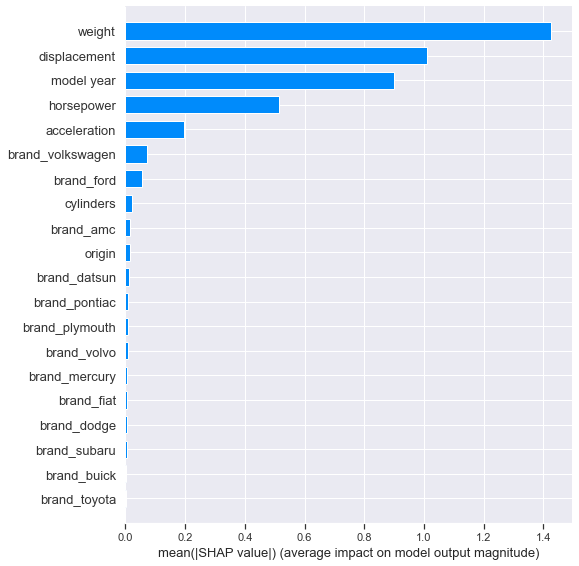

In [101]:
import shap

model = XGBRegressor()
model.fit(X_train_final, y_train)

shap_values = shap.TreeExplainer(model).shap_values(df_final)
shap.summary_plot(shap_values, df_final, plot_type="bar")

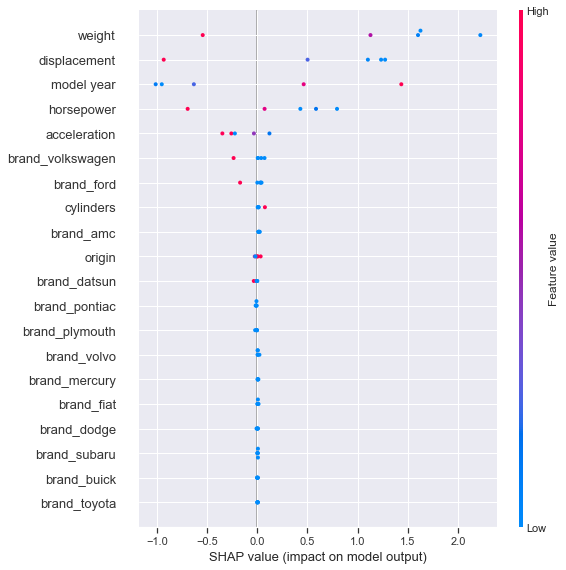

In [102]:
f = plt.figure()
shap.summary_plot(shap_values, df_final)

Berdasarkan penilaian feature, atau impact dari feature, didapat bahwa weight menjadi feature yang berimpact terbesar, namun dari sisi negatif, atau menurunkan

---
---
## Model Saving

In [ ]:
import pickle

with open("imputer.pkl", "wb") as imputer_file:
    pickle.dump(imputer, imputer_file)

with open("anomalydetect.pkl", "wb") as iso_file:
    pickle.dump(iso, iso_file)

with open("pipeline.pkl", "wb") as pipe_file:
    pickle.dump(pipeline_model(xgb),pipe_file)

---
---
## Model Inference

In [ ]:
data_inf = cars_df.sample(10, random_state=10)

In [ ]:
data_inf

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,km/l,brand
331,4,97.0,67.0,2145,18.0,80,3,14.369867,subaru
111,3,70.0,90.0,2124,13.5,73,3,7.652592,mazda
350,4,105.0,63.0,2215,14.9,81,1,14.752497,plymouth
205,4,97.0,75.0,2155,16.4,76,3,11.904032,toyota
56,4,91.0,70.0,1955,20.5,71,1,11.053744,plymouth
377,4,91.0,68.0,1970,17.6,82,3,13.179464,mazda
81,4,97.0,92.0,2288,17.0,72,3,11.904032,datsun
214,8,302.0,130.0,3870,15.0,76,1,5.526872,ford
142,4,79.0,67.0,1963,15.5,74,2,11.053744,volkswagen
110,4,108.0,94.0,2379,16.5,73,3,9.353168,datsun


In [ ]:
data_inf.isnull().sum()

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
km/l            0
brand           0
dtype: int64

<AxesSubplot:>

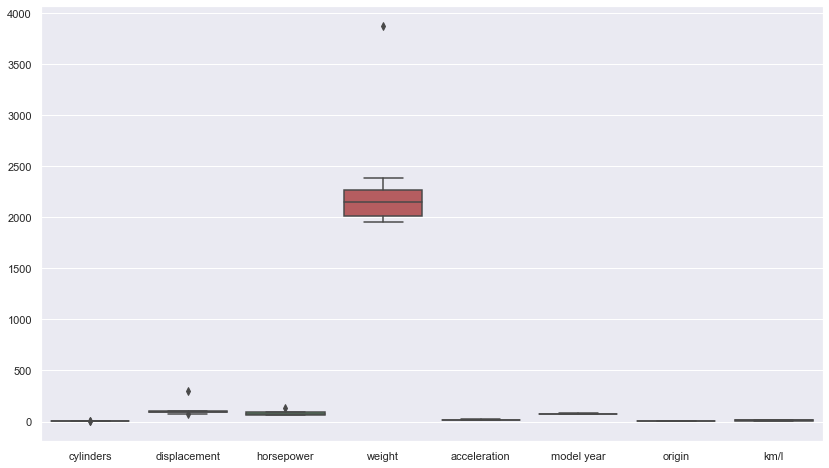

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_inf)

In [ ]:
def calc_outlier(col):
    #cari iqr menggunakan quantile 25% dan 75%
    q1 = np.quantile(data_inf[col], 0.25)
    q3 = np.quantile(data_inf[col], 0.75)
    iqr = q3 - q1

    #cari batas atas dan batas bawah
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    
    print('batas atas dari {} : {} '.format(col, upper))
    print('batas bawah dari {} : {} '.format(col, lower))

    #capping kolom menggunakan batas atas dan batas bawah
    data_inf[col] = np.where(
    data_inf[col] > upper,
    upper,
    np.where(
        data_inf[col] < lower,
        lower,
        data_inf[col]
        )
    )

In [ ]:
calc_outlier('weight')

batas atas dari weight : 2661.625 
batas bawah dari weight : 1616.625 


In [ ]:
y_pred_inf = xgb.predict(data_inf)

In [ ]:
y_pred_inf

array([17.588346, 12.085736, 14.902082, 11.893967, 12.278546, 16.103657,
        9.929651,  9.155162, 12.465549, 10.027792], dtype=float32)

In [ ]:
pd.DataFrame(y_pred_inf, data_inf['km/l'], columns=['km/l - Inference_predict']).reset_index()

,km/l,km/l - Inference_predict
0,14.369867,17.588346
1,7.652592,12.085736
2,14.752497,14.902082
3,11.904032,11.893967
4,11.053744,12.278546
5,13.179464,16.103657
6,11.904032,9.929651
7,5.526872,9.155162
8,11.053744,12.465549
9,9.353168,10.027792


---
---
## Kesimpulan


1.  Objectif dari model yaitu, untuk memprediksi konsumsi bahan bakar dari mobil dengan feature yang dimiliki oleh mobil tersebut
2.  Terdapat 15 feature yang digunakan dalam model ini
3.  Model menggunakan metode Linear regresi dengan teknik : <br>
    - LinearRegression
    - KNN
    - Ridge
    - XGboost
4.  Digunakan Pipeline untuk membuat proses dari preprocessing samapi training model
5.  Model Evaluation menggambarkan bahwa XGboost mendapatkan nilai yang terbaik dengan : <br>
        MAE Train set :  0.01344556158233856
        MAE Test set :  1.0357904748738098

        RMSE Train set :  0.01942748468685166
        RMSE Test set :  1.3996522855972775
        R2 Score :  0.8227704040764127

6.  Prediksi Model Inference digunakan sebagai data baru untuk mengetes apakah model bisa diproses atau tidak
7.  selanjutnya data saving, yang nantinya dapat dijadikan untuk deployment model